# Data processing

In this notebook, I'm collecting the data for the two cities in Peru and Puerto Rico and then combinting the dengue data with other datasets including precipitation, population, and temperature.

## Import libraries

I'll import the libraries needed for combing the various data files and create testing and training data.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Data for Iquitos, Peru

In this specific section, I'll work with the data for Iquitos, Peru and create the data ready for analysis.

### Load datasets

I'm going to load in data files for `dengue`, `population` and `environment`.

In [2]:
dengue = pd.read_csv("data/iquitos/dengue_data.csv")
population = pd.read_csv("data/iquitos/population_data.csv")
environment = pd.read_csv("data/iquitos/environment_data.csv")

### Extract data from `dengue_data`

I'll create new columns of `date` which includes year and month, and two other columns `year` and `month` for making it easier to combine with other data files.

In [3]:
dengue = dengue[["week_start_date", "total_cases"]]
dates = dengue["week_start_date"].str.split('-')
dengue = dengue.assign(date = [year + "-" + month for year, month, _ in dates])
dengue = dengue.assign(year = [int(year) for year, _, _ in dates])
dengue = dengue.assign(month = [int(month) for _, month, _ in dates])
dengue.drop(["week_start_date"], axis = 1)
dengue = dengue[['date', 'year', 'month', 'total_cases']]

I'll now group all the data based on the data and now the `total_cases` will be the total for each month.

In [4]:
dengue = dengue.groupby(['date', 'year', 'month'], as_index=False).sum()

### Visualize the data

I'll next create a line plot and see how the dengue data varies with time.

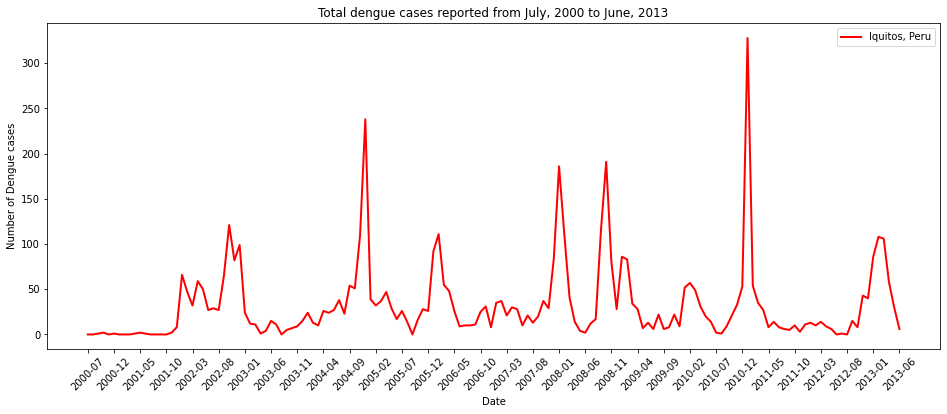

In [5]:
plt.figure(figsize = (16, 6))
plt.plot(dengue['date'], dengue['total_cases'], color = 'red', linewidth = 2, label = 'Iquitos, Peru')
plt.xticks(np.arange(0, 160, 5), rotation = 45)
plt.xlabel("Date")
plt.ylabel("Number of Dengue cases")
plt.title("Total dengue cases reported from July, 2000 to June, 2013")
plt.legend()
plt.show()

There seems to be a few spikes in the data. The first is observed around October-November, 2004, followed by a major spike around December, 2010.

### Combine `population_data` with `dengue_data`

Next, I'll combine the population data with the dengue data we created above.

In [6]:
population = population.rename({"Year": 'year', "Estimated_population": "population"}, axis = 1)
iquitos_df = dengue.merge(population, on = 'year', how='left')

### Combine `environment_data` with `final_df`

The next step in the processing of data before we do any analysis is to refine the data about the environment with the final data frame we created till now.

I begin by removing all rows that have atleast one missing value.

In [7]:
environment_refined = environment[(environment["TMAX"] != -9999) & 
            (environment["TMIN"] != -9999) & 
            (environment["TAVG"] != -9999) &
            (environment["TDTR"] != -9999) & 
            (environment["PRCP"] != -9999)].reset_index(drop = True)

Next, I take the mean values per month per year for temperature data but find the sum per month per year.

In [8]:
environment_refined = environment_refined.groupby(["YYYY", "MM"]).agg({"TMAX": "mean", 
                                                 "TMIN": "mean", 
                                                 "TAVG": "mean", 
                                                 "TDTR": "mean", 
                                                 "PRCP": "sum"}).reset_index()

I rename the columns and create the appropriate date column to be merged with the final data frame.

In [9]:
environment_refined['MM'] = environment_refined.MM.map("{:02}".format)
environment_refined = environment_refined.rename({"YYYY": 'year', "MM": "month"}, axis = 1)
environment_refined['month'] = environment_refined['month'].astype(str)
environment_refined['year'] = environment_refined['year'].astype(str)
environment_refined['date'] = environment_refined['year'].str.cat(environment_refined['month'], sep = '-')

I'll add precipitatiom values for the last two months as well as it is likely that the dengue cases may be affected by the rainfall that happened a few days ago.

In [10]:
prcp_1 = np.insert(np.array(environment_refined['PRCP'][:-1]), 0, 0)
prcp_2 = np.insert(prcp_1[:-1], 0, 0)
environment_refined['PRCP(-1)'] = prcp_1
environment_refined['PRCP(-2)'] = prcp_2

I'll combine the data frames into one.

In [11]:
iquitos_df = iquitos_df.merge(environment_refined, on = 'date', how='left')

I'll now remove all the columns that are not needed:
- year_x
- month_x
- year_y
- month_y

I'll also rearrange the columns in a specific order.

In [12]:
iquitos_df = iquitos_df.drop(['year_x', 'month_x', 'year_y', 'month_y'], axis = 1)
iquitos_df = iquitos_df[['date', 'population', 'TMAX', 'TMIN', 'TAVG', 'TDTR', 'PRCP(-1)', 
                     'PRCP(-2)', 'PRCP', 'total_cases']]

The final view of the data.

In [13]:
iquitos_df.head()

,date,population,TMAX,TMIN,TAVG,TDTR,PRCP(-1),PRCP(-2),PRCP,total_cases
0,2000-07,386666,31.458333,20.325000,25.916667,11.133333,85.8,309.3,97.3,0
1,2000-08,386666,32.864706,21.170588,27.017647,11.694118,97.3,85.8,225.2,0
2,2000-09,386666,33.300000,20.925000,27.108333,12.375000,225.2,97.3,247.1,1
3,2000-10,386666,33.163636,21.709091,27.436364,11.454545,247.1,225.2,81.2,2
4,2000-11,386666,33.400000,21.550000,27.475000,11.850000,81.2,247.1,25.4,0


### Save the data

Finally, I'll save the created data frame into a file to be used for analysis.

In [14]:
iquitos_df.to_csv("data/iquitos/combined_data.csv", index = False)

## Data for San Juan, Puerto Rico

In this specific section, I'll work with the data for San Juan, Puerto Rico and create the data ready for analysis.

### Load datasets

I'm going to load in data files for `dengue`, `population` and `environment`.

In [15]:
dengue = pd.read_csv("data/san_juan/dengue_data.csv")
population = pd.read_csv("data/san_juan/population_data.csv")
environment = pd.read_csv("data/san_juan/environment_data.csv")

### Extract data from `dengue_data`

I'll create new columns of `date` which includes year and month, and two other columns `year` and `month` for making it easier to combine with other data files.

In [16]:
dengue = dengue[["week_start_date", "total_cases"]]
dates = dengue["week_start_date"].str.split('-')
dengue = dengue.assign(date = [year + "-" + month for year, month, _ in dates])
dengue = dengue.assign(year = [int(year) for year, _, _ in dates])
dengue = dengue.assign(month = [int(month) for _, month, _ in dates])
dengue.drop(["week_start_date"], axis = 1)
dengue = dengue[['date', 'year', 'month', 'total_cases']]

I'll now group all the data based on the data and now the `total_cases` will be the total for each month.

In [17]:
dengue = dengue.groupby(['date', 'year', 'month'], as_index=False).sum()

### Visualize the data

I'll next create a line plot and see how the dengue data varies with time.

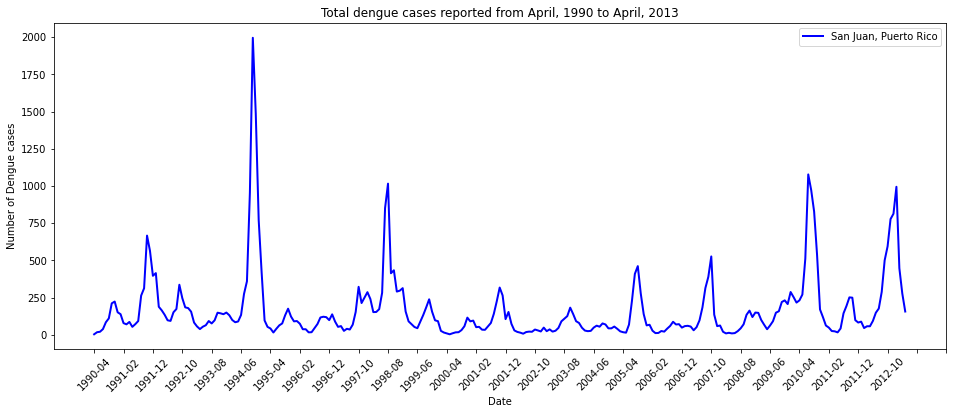

In [18]:
plt.figure(figsize = (16, 6))
plt.plot(dengue['date'], dengue['total_cases'], color = 'blue', linewidth = 2, label = 'San Juan, Puerto Rico')
plt.xticks(np.arange(0, 300, 10), rotation = 45)
plt.xlabel("Date")
plt.ylabel("Number of Dengue cases")
plt.title("Total dengue cases reported from April, 1990 to April, 2013")
plt.legend()
plt.show()

There seems to be a few spikes in the data. The first is observed around December, 1995, followed by three more spikes. It's easy to see that the number of Dengue cases are much higher even for the same period as observed in Iquitos. For Iquitos, the highest was around 300.

### Combine `population_data` with `dengue_data`

Next, I'll combine the population data with the dengue data we created above.

In [19]:
population = population.rename({"Year": 'year', "Estimated_population": "population"}, axis = 1)
san_juan_df = dengue.merge(population, on = 'year', how='left')

### Combine `environment_data` with `final_df`

The next step in the processing of data before we do any analysis is to refine the data about the environment with the final data frame we created till now.

I begin by removing all rows that have atleast one missing value.

In [20]:
environment_refined = environment[(environment["TMAX"] != -9999) & 
            (environment["TMIN"] != -9999) & 
            (environment["TAVG"] != -9999) &
            (environment["TDTR"] != -9999) & 
            (environment["PRCP"] != -9999)].reset_index(drop = True)

Next, I take the mean values per month per year for temperature data but find the sum per month per year.

In [21]:
environment_refined = environment_refined.groupby(["YYYY", "MM"]).agg({"TMAX": "mean", 
                                                 "TMIN": "mean", 
                                                 "TAVG": "mean", 
                                                 "TDTR": "mean", 
                                                 "PRCP": "sum"}).reset_index()

I rename the columns and create the appropriate date column to be merged with the final data frame.

In [22]:
environment_refined['MM'] = environment_refined.MM.map("{:02}".format)
environment_refined = environment_refined.rename({"YYYY": 'year', "MM": "month"}, axis = 1)
environment_refined['month'] = environment_refined['month'].astype(str)
environment_refined['year'] = environment_refined['year'].astype(str)
environment_refined['date'] = environment_refined['year'].str.cat(environment_refined['month'], sep = '-')

I'll add precipitatiom values for the last two months as well as it is likely that the dengue cases may be affected by the rainfall that happened a few days ago.

In [23]:
prcp_1 = np.insert(np.array(environment_refined['PRCP'][:-1]), 0, 0)
prcp_2 = np.insert(prcp_1[:-1], 0, 0)
environment_refined['PRCP(-1)'] = prcp_1
environment_refined['PRCP(-2)'] = prcp_2

I'll combine the data frames into one.

In [24]:
san_juan_df = san_juan_df.merge(environment_refined, on = 'date', how='left')

I'll now remove all the columns that are not needed:
- year_x
- month_x
- year_y
- month_y

I'll also rearrange the columns in a specific order.

In [25]:
san_juan_df = san_juan_df.drop(['year_x', 'month_x', 'year_y', 'month_y'], axis = 1)
san_juan_df = san_juan_df[['date', 'population', 'TMAX', 'TMIN', 'TAVG', 'TDTR', 'PRCP(-1)', 
                     'PRCP(-2)', 'PRCP', 'total_cases']]

The final view of the data.

In [26]:
san_juan_df.head()

,date,population,TMAX,TMIN,TAVG,TDTR,PRCP(-1),PRCP(-2),PRCP,total_cases
0,1990-04,2217968.0,29.966667,22.356667,26.166667,7.610000,79.9,76.8,26.8,4
1,1990-05,2217968.0,31.245161,23.958065,27.583871,7.287097,26.8,79.9,61.8,18
2,1990-06,2217968.0,31.450000,24.513333,27.986667,6.936667,61.8,26.8,109.8,21
3,1990-07,2217968.0,31.703226,24.441935,28.077419,7.261290,109.8,61.8,146.4,39
4,1990-08,2217968.0,31.767742,24.777419,28.277419,6.990323,146.4,109.8,86.9,85


### Save the data

Finally, I'll save the created data frame into a file to be used for analysis.

In [27]:
san_juan_df.to_csv("data/san_juan/combined_data.csv", index = False)

## Single data file

I'll finally save the two data files together into one for easy access as and when needed.

In [28]:
iquitos_df['place'] = 'Iquitos'
san_juan_df['place'] = 'San Juan'

In [29]:
final_df = iquitos_df.append(san_juan_df, ignore_index=True)

In [30]:
final_df.to_csv("data/complete_data.csv", index = False)